DBI score: 1.1055529700461062


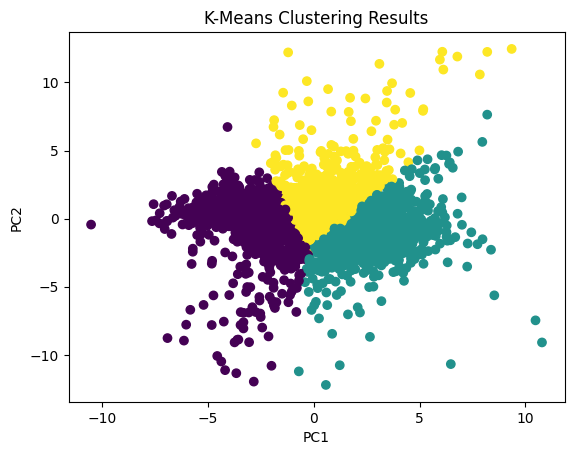

Best configuration: PCA components=3, Number of clusters=3, DBI=1.1234325361563011


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def normalize_data(data):
    # Normalize the data by subtracting the mean and dividing by the standard deviation
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data


def calculate_covariance_matrix(data):
    # Calculate the covariance matrix
    num_samples = data.shape[0]
    covariance_matrix = (1 / (num_samples - 1)) * np.dot(data.T, data)
    return covariance_matrix


def perform_pca(data, n_components):
    # Normalize the data
    normalized_data = normalize_data(data)

    # Calculate the covariance matrix
    covariance_matrix = calculate_covariance_matrix(normalized_data)

    # Perform eigendecomposition on the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Select the top n_components eigenvectors
    selected_eigenvectors = sorted_eigenvectors[:, :n_components]

    # Transform the data into the new feature space
    transformed_data = np.dot(normalized_data, selected_eigenvectors)

    return transformed_data


def initialize_centroids(data, n_clusters):
    # Randomly select n_clusters data points as initial centroids
    indices = np.random.choice(range(data.shape[0]), size=n_clusters, replace=False)
    centroids = data[indices]
    return centroids


def assign_labels(data, centroids):
    # Calculate the Euclidean distance between each data point and each centroid
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    # Assign each data point to the closest centroid
    labels = np.argmin(distances, axis=1)
    return labels


def update_centroids(data, labels, n_clusters):
    centroids = np.zeros((n_clusters, data.shape[1]))
    for i in range(n_clusters):
        cluster_points = data[labels == i]
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)
    return centroids


def kmeans(data, n_clusters, max_iter=300):
    # Step 1: Initialize the centroids
    centroids = initialize_centroids(data, n_clusters)

    for _ in range(max_iter):
        # Step 2: Assign labels to data points
        labels = assign_labels(data, centroids)

        # Step 3: Update centroids
        new_centroids = update_centroids(data, labels, n_clusters)

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels


def calculate_DBI(data, labels):
    num_clusters = len(np.unique(labels))
    cluster_centers = np.array([np.mean(data[labels == i], axis=0) for i in range(num_clusters)])
    cluster_distances = np.linalg.norm(cluster_centers[:, np.newaxis] - cluster_centers, axis=2)
    cluster_avg_distances = np.array([np.mean(np.linalg.norm(data[labels == i] - cluster_centers[i], axis=1))
                                      for i in range(num_clusters)])
    pairwise_distances = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                pairwise_distances[i, j] = (cluster_avg_distances[i] + cluster_avg_distances[j]) / cluster_distances[i, j]

    DBI = np.mean(np.max(pairwise_distances, axis=1))

    return DBI


# Step 1: Load the dataset
data = pd.read_csv("Spellman.csv")

# Step 2: Preprocess the dataset
data = data.dropna()  # Remove rows with missing values
data = data.select_dtypes(include=np.number)  # Keep only numeric columns

# Step 3: Perform PCA
n_components = 2
pca_data = perform_pca(data.values, n_components)

# Step 4: Perform K-Means clustering
n_clusters = 3
labels = kmeans(pca_data, n_clusters)

# Step 5: Calculate DBI
DBI = calculate_DBI(pca_data, labels)

print("DBI score:", DBI)

# Step 6: Visualize the clustering results
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering Results')
plt.show()

best_configurations = []
best_DBI = -np.inf

# Step 6: Find the best configuration
for n_components in range(2, 11):
    for n_clusters in range(3, 5):
        # Step 4: Perform K-Means clustering
        labels = kmeans(pca_data, n_clusters)

        # Step 5: Calculate DBI
        DBI = calculate_DBI(pca_data, labels)

        # Check if current configuration is better than the previous best
        if DBI > best_DBI:
            best_DBI = DBI
            best_configurations = [(n_components, n_clusters)]
        elif DBI == best_DBI:
            best_configurations.append((n_components, n_clusters))

# Print the best configurations
for config in best_configurations:
    print(f"Best configuration: PCA components={config[0]}, Number of clusters={config[1]}, DBI={best_DBI}")